In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_ei_basic
from bo_functions import ExactGPModel
from bo_functions import calc_GP_outputs
from bo_functions import train_GP_model

from bo_plotters import y_plotter_basic
from bo_plotters import stdev_plotter_basic
from bo_plotters import ei_plotter_basic

In [2]:
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])

In [4]:
# from bo_functions import create_sse_data
# Theta1 =  np.linspace(-2,2,10) #1x10
# Theta2 =  np.linspace(-2,2,10) #1x10
# theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
# train_T = torch.tensor(theta_mesh.T.reshape(-1, 2)) #25 x 2
# train_sse = create_sse_data(train_T, Xexp, Yexp)
# Note - If using for comparison make sure to change test space accordingly

In [5]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_T, train_sse, likelihood)

In [6]:
#Training the GP Model
iterations = 500
train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = True)

Iter 1/500 - Loss: 5220.767   lengthscale: 0.693   noise: 0.693   output scale: 0.693 
Iter 2/500 - Loss: 4649.822   lengthscale: 0.744   noise: 0.744   output scale: 0.744 
Iter 3/500 - Loss: 4161.662   lengthscale: 0.798   noise: 0.798   output scale: 0.798 
Iter 4/500 - Loss: 3746.490   lengthscale: 0.853   noise: 0.853   output scale: 0.853 
Iter 5/500 - Loss: 3394.335   lengthscale: 0.909   noise: 0.910   output scale: 0.910 
Iter 6/500 - Loss: 3095.757   lengthscale: 0.966   noise: 0.967   output scale: 0.969 
Iter 7/500 - Loss: 2842.250   lengthscale: 1.022   noise: 1.026   output scale: 1.028 
Iter 8/500 - Loss: 2626.406   lengthscale: 1.079   noise: 1.086   output scale: 1.089 
Iter 9/500 - Loss: 2441.915   lengthscale: 1.134   noise: 1.146   output scale: 1.149 
Iter 10/500 - Loss: 2283.478   lengthscale: 1.189   noise: 1.206   output scale: 1.211 
Iter 11/500 - Loss: 2146.689   lengthscale: 1.241   noise: 1.266   output scale: 1.272 
Iter 12/500 - Loss: 2027.906   lengthscal

Iter 129/500 - Loss: 547.055   lengthscale: 1.693   noise: 5.013   output scale: 4.454 
Iter 130/500 - Loss: 544.981   lengthscale: 1.693   noise: 5.031   output scale: 4.470 
Iter 131/500 - Loss: 542.930   lengthscale: 1.692   noise: 5.050   output scale: 4.486 
Iter 132/500 - Loss: 540.900   lengthscale: 1.691   noise: 5.068   output scale: 4.502 
Iter 133/500 - Loss: 538.891   lengthscale: 1.691   noise: 5.086   output scale: 4.517 
Iter 134/500 - Loss: 536.903   lengthscale: 1.690   noise: 5.105   output scale: 4.533 
Iter 135/500 - Loss: 534.935   lengthscale: 1.690   noise: 5.123   output scale: 4.548 
Iter 136/500 - Loss: 532.988   lengthscale: 1.689   noise: 5.141   output scale: 4.564 
Iter 137/500 - Loss: 531.061   lengthscale: 1.689   noise: 5.159   output scale: 4.579 
Iter 138/500 - Loss: 529.153   lengthscale: 1.688   noise: 5.177   output scale: 4.594 
Iter 139/500 - Loss: 527.264   lengthscale: 1.688   noise: 5.195   output scale: 4.610 
Iter 140/500 - Loss: 525.394   l

Iter 262/500 - Loss: 380.787   lengthscale: 1.649   noise: 7.044   output scale: 6.212 
Iter 263/500 - Loss: 380.014   lengthscale: 1.648   noise: 7.057   output scale: 6.223 
Iter 264/500 - Loss: 379.245   lengthscale: 1.648   noise: 7.070   output scale: 6.235 
Iter 265/500 - Loss: 378.480   lengthscale: 1.648   noise: 7.083   output scale: 6.246 
Iter 266/500 - Loss: 377.719   lengthscale: 1.647   noise: 7.096   output scale: 6.257 
Iter 267/500 - Loss: 376.963   lengthscale: 1.647   noise: 7.109   output scale: 6.268 
Iter 268/500 - Loss: 376.210   lengthscale: 1.647   noise: 7.121   output scale: 6.280 
Iter 269/500 - Loss: 375.461   lengthscale: 1.646   noise: 7.134   output scale: 6.291 
Iter 270/500 - Loss: 374.716   lengthscale: 1.646   noise: 7.147   output scale: 6.302 
Iter 271/500 - Loss: 373.975   lengthscale: 1.646   noise: 7.160   output scale: 6.313 
Iter 272/500 - Loss: 373.238   lengthscale: 1.645   noise: 7.173   output scale: 6.325 
Iter 273/500 - Loss: 372.504   l

Iter 395/500 - Loss: 303.905   lengthscale: 1.608   noise: 8.593   output scale: 7.577 
Iter 396/500 - Loss: 303.470   lengthscale: 1.607   noise: 8.604   output scale: 7.586 
Iter 397/500 - Loss: 303.035   lengthscale: 1.607   noise: 8.614   output scale: 7.595 
Iter 398/500 - Loss: 302.603   lengthscale: 1.607   noise: 8.625   output scale: 7.605 
Iter 399/500 - Loss: 302.172   lengthscale: 1.606   noise: 8.635   output scale: 7.614 
Iter 400/500 - Loss: 301.742   lengthscale: 1.606   noise: 8.646   output scale: 7.623 
Iter 401/500 - Loss: 301.314   lengthscale: 1.606   noise: 8.656   output scale: 7.633 
Iter 402/500 - Loss: 300.887   lengthscale: 1.606   noise: 8.667   output scale: 7.642 
Iter 403/500 - Loss: 300.462   lengthscale: 1.605   noise: 8.677   output scale: 7.651 
Iter 404/500 - Loss: 300.038   lengthscale: 1.605   noise: 8.688   output scale: 7.661 
Iter 405/500 - Loss: 299.616   lengthscale: 1.605   noise: 8.698   output scale: 7.670 
Iter 406/500 - Loss: 299.195   l

In [7]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval()

p=10
#Define Testing Space
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta_space = torch.tensor(theta_mesh.T.reshape(-1, 2)) #25 x 2
# print(test_T)

In [8]:
GP_Output = calc_GP_outputs(model, likelihood, theta_space)

model_mean = GP_Output[0]
model_variance = GP_Output[1]
model_stdev = GP_Output[2]
model_sse = GP_Output[3]

#Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
Theta_Opt_GP = theta_space[np.argmin(model_sse)].numpy() #1x2
print("The GP predicts that Theta1 =",Theta_Opt_GP[0],"and Theta2 =", Theta_Opt_GP[1])

#calculates best_error and expected improvement
best_error = np.argmax(model_sse)
ei = calc_ei_basic(best_error,model_mean,model_variance)

#Formats ei points into a suitable graphing form    
ei_map = ei.reshape(len(Theta1),-1) # 5x5
#Formats sse data points into a suitable graphing form    
sse_map = model_sse.reshape(len(Theta1),-1) #5 x 5
#Formats stdev data points into suitable graphing form
stdev_map = model_stdev.reshape(len(Theta1),-1) #5 x 5
# print(stdev_map)

The GP predicts that Theta1 = 1.1111111111111107 and Theta2 = -1.5555555555555556


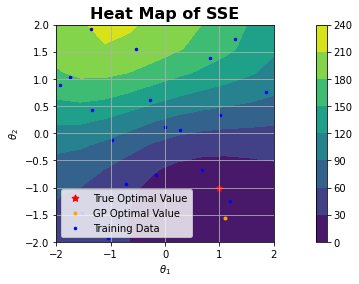

In [9]:
title = "SSE"
Theta_True = np.array([1,-1])
y_plotter_basic(theta_mesh, sse_map, Theta_True, Theta_Opt_GP, train_T,title,plot_train=True)

## Analysis of SSE
 - The GP predicts the optimal value excatly
 - The sum of squared error is closest to zero in the region closest to the actual optimal value of vector $\bar{\theta}$. This signifies that the GP is accurately predicting $\bar{\theta}$
 - The sum of squared error is greatest in the region as $\theta_1$ and $\theta_2$ deviate from their optimal values. This is further evidence that the GP is accurately predicting $\bar{\theta}$

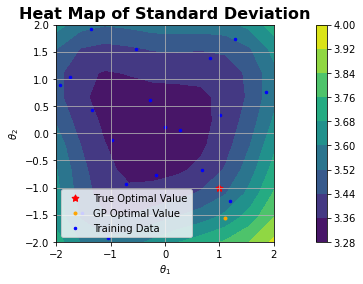

In [10]:
stdev_plotter_basic(theta_mesh, stdev_map,Theta_True, Theta_Opt_GP,train_T,plot_train=True)

## Analysis of Standard Deviation
 - The GP predicts the standard deviation is smallest when $\bar{\theta} = [0,0]$
 - The standard  deviation increases as $\bar{\theta}$ deviates further from zero
 - My guess is that this graph is cenetered at zero because the sse is independent of $\bar{\theta}$ at $\bar{\theta}=0$

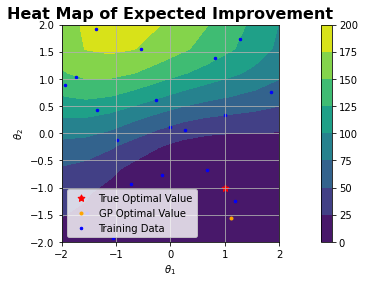

In [11]:
ei_plotter_basic(theta_mesh, ei_map, Theta_True, Theta_Opt_GP,train_T,plot_train=True)

## Analysis of Expected Improvement
 - The GP predicts the expected improvement is largest away from the optimal value. This is reasonable because the output of the GP is the SSE, which is largest away from the optimal point
 - The expected improvement is smallest in the area closest to $\bar{\theta}_{true}$ which makes sense because the error should be largest far away from the optimal point.